## Домашнее задание №7

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

In [29]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import MNIST
from tqdm.notebook import tqdm, trange

from matplotlib import pyplot as plt
from IPython.display import clear_output

### Задача №1:
Обратимся к классической задаче распознавания рукописных цифр. Мы будем работать с набором данных [MNIST](http://yann.lecun.com/exdb/mnist/). В данном задании воспользуемся всем датасетом целиком.

__Ваша основная задача: реализовать весь пайплан обучения модели и добиться качества $\geq 92\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбуку первого занятия.

Настоятельно рекомендуем написать код "с нуля", лишь поглядывая на готовые примеры, а не просто "скопировать-вставить". Это поможет вам в дальнейшем.

100%|██████████| 9912422/9912422 [00:00<00:00, 19032131.94it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 68554439.06it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26495637.87it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12794176.47it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Text(0.5, 1.0, 'Image label: 1')

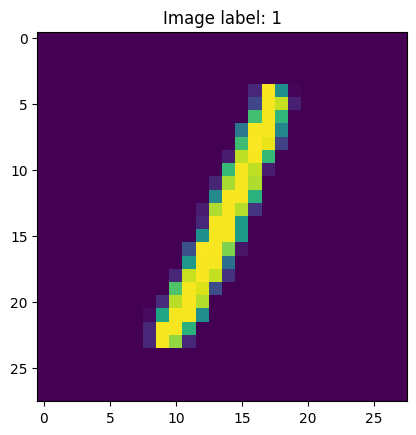

In [2]:
# do not change the code in the block below
# __________start of block__________

train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)


train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 92% accuracy.

*Комментарий: для этого достаточно линейных слоев и функций активации.*

__Внимание, ваша модель должна быть представлена именно переменной `model`.__

In [22]:
# your code here
class LaNet(nn.Module):
    def __init__(self):
        super(LaNet, self).__init__()

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.norm1 = nn.BatchNorm2d(num_features=6)
        self.norm2 = nn.BatchNorm2d(num_features=16)
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)   # picture size after poolings = 5 x 5
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        x = self.unflatten(x)
        x = self.pool(self.relu(self.norm1(self.conv1(x))))
        x = self.pool(self.relu(self.norm2(self.conv2(x))))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))

        return x

In [23]:
# Creating model instance
# your code here
model = LaNet()

Локальные тесты для проверки вашей модели доступны ниже:

In [24]:
# do not change the code in the block below
# __________start of block__________
assert model is not None, 'Please, use `model` variable to store your model'

try:
    x = random_batch[0].reshape(-1, 784)
    y = random_batch[1]

    # compute outputs given inputs, both are variables
    y_predicted = model(x)
except Exception as e:
    print('Something is wrong with the model')
    raise e


assert y_predicted.shape[-1] == 10, 'Model should predict 10 logits/probas'

print('Everything seems fine!')
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Рекомендуем поработать с различными оптимизаторами.

In [27]:
# your code here
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, amsgrad=True, betas=(0.5, 0.999))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)

In [31]:
# your code here
epochs = 10
train_losses = []
train_accuracy = []
best_score = 0.
pbar = trange(epochs, desc="Epoch")
for epoch in pbar:
    print("--------------- Epoch %d/%d ---------------" % (epoch+1, epochs))
    tr_loss = 0
    tr_corr = 0
    model.train()
    for data, target in tqdm(train_data_loader):
        optimizer.zero_grad()
        X_batch, y_batch = data.reshape(-1, 784), target
        logits = model(X_batch)
        preds = torch.argmax(logits, dim=1)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        tr_loss = loss.item() * X_batch.size(0)
        correct = (preds==y_batch).sum()
        tr_corr += correct.item()

    train_loss = tr_loss / len(train_data_loader.sampler)
    train_losses.append(train_loss)
    train_acc = tr_corr / len(train_data_loader.sampler)
    train_accuracy.append(train_acc)
    print("Train loss =", train_loss)
    print("Train accuracy = {:.4f}".format(train_acc))

    scheduler.step()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

--------------- Epoch 1/10 ---------------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss = 0.0007793110529581706
Train accuracy = 0.8965
--------------- Epoch 2/10 ---------------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss = 0.0007812450408935547
Train accuracy = 0.9753
--------------- Epoch 3/10 ---------------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss = 0.0007943717956542969
Train accuracy = 0.9814
--------------- Epoch 4/10 ---------------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss = 0.0007835992177327474
Train accuracy = 0.9861
--------------- Epoch 5/10 ---------------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss = 0.0007957393646240234
Train accuracy = 0.9880
--------------- Epoch 6/10 ---------------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss = 0.0007793567021687826
Train accuracy = 0.9891
--------------- Epoch 7/10 ---------------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss = 0.0007793018341064453
Train accuracy = 0.9915
--------------- Epoch 8/10 ---------------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss = 0.0007799503962198893
Train accuracy = 0.9924
--------------- Epoch 9/10 ---------------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss = 0.0007856018702189128
Train accuracy = 0.9931
--------------- Epoch 10/10 ---------------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss = 0.0007792828241984049
Train accuracy = 0.9941


Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [32]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in train_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [33]:
print(f'Neural network accuracy on train set: {train_acc:3.5}')

Neural network accuracy on train set: 0.995


In [34]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [35]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.9894


Проверка, что необходимые пороги пройдены:

In [36]:
assert test_acc >= 0.92, 'Test accuracy is below 0.92 threshold'
assert train_acc >= 0.91, 'Train accuracy is below 0.91 while test accuracy is fine. We recommend to check your model and data flow'

### Сдача задания
Загрузите файл `hw07_data_dict.npy` (ссылка есть на странице с заданием) и запустите код ниже для генерации посылки. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).

In [37]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23s_dd_ml/homeworks/hw07_mnist_classification/hw07_data_dict.npy

--2023-11-18 21:56:21--  https://raw.githubusercontent.com/girafe-ai/ml-course/23s_dd_ml/homeworks/hw07_mnist_classification/hw07_data_dict.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6272438 (6.0M) [application/octet-stream]
Saving to: ‘hw07_data_dict.npy’

hw07_data_dict.npy  100%[===================>]   5.98M  --.-KB/s    in 0.09s   

2023-11-18 21:56:21 (63.9 MB/s) - ‘hw07_data_dict.npy’ saved [6272438/6272438]



In [38]:
# do not change the code in the block below
# __________start of block__________
import os

assert os.path.exists('hw07_data_dict.npy'), 'Please, download `hw07_data_dict.npy` and place it in the working directory'

def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx:idx+step].reshape(-1, 784))
            predicted_labels.append(y_predicted.argmax(dim=1))

    predicted_labels = torch.cat(predicted_labels)
    return predicted_labels

loaded_data_dict = np.load('hw07_data_dict.npy', allow_pickle=True)

submission_dict = {
    'train': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['train'])).numpy(),
    'test': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['test'])).numpy()
}

np.save('submission_dict_hw07.npy', submission_dict, allow_pickle=True)
print('File saved to `submission_dict_hw07.npy`')
# __________end of block__________

File saved to `submission_dict_hw07.npy`


На этом задание завершено. Поздравляем!